# House Prices: Advanced Regression Techniques

## Table of Contents
- <b>Introduction</b>
- <b>Data Processing</b>
    - Outliers
    - Target variable
- <b>Feature engineering</b>
    - Missing data
        - <i>Exploration</i>
        - <i>Imputation</i>
    - Converting features
- <b>Machine Learning</b>
    - Set up
    - Initiating algorithms
        - <i>Generalized linear models</i>
        - <i>Ensemble methods (Gradient tree boosting)</i>
    - Fitting algorithms
        - <i>Fit all models</i>
        - <i>Rank model performance</i>
    - Stacking algorithms
- <b>Final predictions</b>

## Introduction

Hello Kagglers! In this kernel i'll be taking on the Kaggle Competition: 'House Prices: Advanced Regression Techniques'. This competition uses the Ames Housing Dataset, which itself contains 1460 observations in both training and tests sets, and 80 features to boot. The challenge is to predict property Sale Price, hence this is a Regression problem. 

Throughout this kernel I will provide explanations about my code so you can understand the logic behind each action. While i'll conduct some feature engineering, my main focus will be to explore the predictive models and hopefully build an effective stacked model for final prediction.

At the time of posting, this model achieved a score within the top 12% of the Leaderboard, achieved through a simple approach to stacking.

Well that's enough from me - enjoy the read and please feel free to share with me any feedback regarding my code or overall approach! I'm always looking to improve :).

In [1]:
# All project packages imported at the start

# Project packages
import pandas as pd
import numpy as np

# Visualisations
import matplotlib.pyplot as plt 
import seaborn as sns

# Statistics
from scipy import stats
from scipy.stats import norm, skew
from statistics import mode
from scipy.special import boxcox1p

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, Ridge, RidgeCV, ElasticNet
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from catboost import Pool, CatBoostRegressor, cv

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# Reading in the data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
# Inspecting the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
# And now the test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

There a lot of object dtypes and a lot of missing values within this dataset. We'll need to consider these during data processing. 

TO add, a lot of features have been abbreviated. For reference, here are their full names along with a brief explanation:

- SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
- MSSubClass: The building class
- MSZoning: The general zoning classification
- LotFrontage: Linear feet of street connected to property
- LotArea: Lot size in square feet
- Street: Type of road access
- Alley: Type of alley access
- LotShape: General shape of property
- LandContour: Flatness of the property
- Utilities: Type of utilities available
- LotConfig: Lot configuration
- LandSlope: Slope of property
- Neighborhood: Physical locations within Ames city limits
- Condition1: Proximity to main road or railroad
- Condition2: Proximity to main road or railroad (if a second is present)
- BldgType: Type of dwelling
- HouseStyle: Style of dwelling
- OverallQual: Overall material and finish quality
- OverallCond: Overall condition rating
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date
- RoofStyle: Type of roof
- RoofMatl: Roof material
- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)
- MasVnrType: Masonry veneer type
- MasVnrArea: Masonry veneer area in square feet
- ExterQual: Exterior material quality
- ExterCond: Present condition of the material on the exterior
- Foundation: Type of foundation
- BsmtQual: Height of the basement
- BsmtCond: General condition of the basement
- BsmtExposure: Walkout or garden level basement walls
- BsmtFinType1: Quality of basement finished area
- BsmtFinSF1: Type 1 finished square feet
- BsmtFinType2: Quality of second finished area (if present)
- BsmtFinSF2: Type 2 finished square feet
- BsmtUnfSF: Unfinished square feet of basement area
- TotalBsmtSF: Total square feet of basement area
- Heating: Type of heating
- HeatingQC: Heating quality and condition
- CentralAir: Central air conditioning
- Electrical: Electrical system
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet
- LowQualFinSF: Low quality finished square feet (all floors)
- GrLivArea: Above grade (ground) living area square feet
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms
- FullBath: Full bathrooms above grade
- HalfBath: Half baths above grade
- Bedroom: Number of bedrooms above basement level
- Kitchen: Number of kitchens
- KitchenQual: Kitchen quality
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- Functional: Home functionality rating
- Fireplaces: Number of fireplaces
- FireplaceQu: Fireplace quality
- GarageType: Garage location
- GarageYrBlt: Year garage was built
- GarageFinish: Interior finish of the garage
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- GarageQual: Garage quality
- GarageCond: Garage condition
- PavedDrive: Paved driveway
- WoodDeckSF: Wood deck area in square feet
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet
- PoolArea: Pool area in square feet
- PoolQC: Pool quality
- Fence: Fence quality
- MiscFeature: Miscellaneous feature not covered in other categories
- MiscVal: $Value of miscellaneous feature
- MoSold: Month Sold
- YrSold: Year Sold
- SaleType: Type of sale
- SaleCondition: Condition of sale

In [5]:
# Viewing the first 10 observations
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,

In [6]:
# Let's get confirmation on the dataframe shapes
print("\nThe train data size is: {} ".format(train.shape)) 
print("The test data size is: {} ".format(test.shape))


The train data size is: (1460, 81) 
The test data size is: (1459, 80) 


That gives a better feel for what we are initally working with. As one final step pre-data processing, I'm going to take a copy of the ID column and remove it from both dataframes, since this is only needed when submitting final predictions to the Kaggle leaderboard, as opposed to be helpful within any predictive model.

In [7]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the 'Id' colum since it's unnecessary for the prediction process
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Data Processing

## Outliers

The Ames dataset documentation reveals two outliers in the feature GrLivArea (Above grade (ground) living area square feet) - let's inspect these with a quick graph:

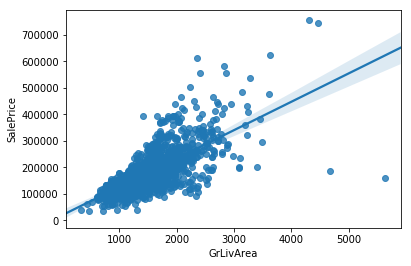

In [8]:
# Checking for outliers in GrLivArea as indicated in dataset documentation
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=True)
plt.show()

Yep, two pretty clear outliers in the bottom right hand corner. It's not always appropriate to delete outliers - removing too many can actually detriment the model's quality. These two however look relatively safe, and with backing from the documentation i'm going to go ahead and clear them.

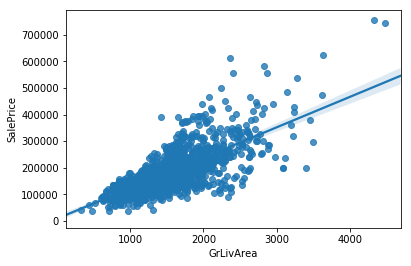

In [9]:
# Removing two very extreme outliers in the bottom right hand corner
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Re-check graph
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=True)
plt.show()

The updated graph is looking better now. Praise to the documentation!

## Target Variable

Let's now learn more about the Target Variable - Sale Price. I'm particularly interested in detecting any skew which would become problematic during the modelling phase.


 mu = 180932.92 and sigma = 79467.79



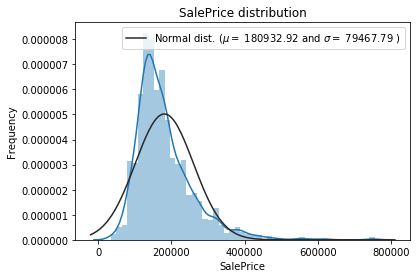

In [10]:
(mu, sigma) = norm.fit(train['SalePrice'])

# 1. Plot Sale Price
sns.distplot(train['SalePrice'] , fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

# Get the fitted parameters used by the function
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

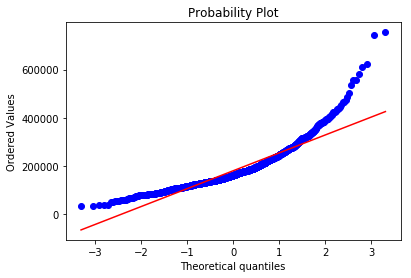

In [11]:
# 2. Plot SalePrice as a QQPlot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

We can see here the Target Variable is right skewed. A log transformation should help bring it back to normality. The code below will complete this.

In [12]:
# Applying a log(1+x) transformation to SalePrice
train["SalePrice"] = np.log1p(train["SalePrice"])


 mu = 12.02 and sigma = 0.40



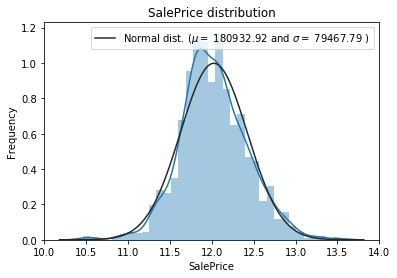

In [13]:
# 1. Plot Sale Price
sns.distplot(train['SalePrice'] , fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

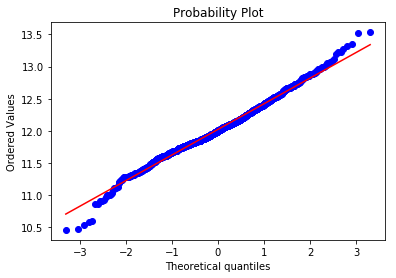

In [14]:
# 2. Plot SalePrice as a QQPlot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

A thing of beauty - the target variable now looks far more amenable for modelling. Let's move on now to some feature engineering.

# Feature Engineering

Firstly,  I will compile all data into a single dataset to save code duplication across both train & test sets:

In [15]:
# Saving train & test shapes
ntrain = train.shape[0]
ntest = test.shape[0]

# Creating y_train variable
y_train = train.SalePrice.values

# New all encompassing dataset
all_data = pd.concat((train, test)).reset_index(drop=True)

# Dropping the target
all_data.drop(['SalePrice'], axis=1, inplace=True)

# Printing all_data shape
print("all_data size is: {}".format(all_data.shape))

all_data size is: (2917, 79)


## Missing data

### Exploration
As was evident when initially inspecting the data, many feature variable are missing values. To get a better sense of this, I will compile a ranked table of missing values by the % of data missing.

In [16]:
# Getting a missing % count
all_data_missing = (all_data.isnull().sum() / len(all_data)) * 100
all_data_missing = all_data_missing.drop(all_data_missing[all_data_missing == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Percentage':all_data_missing})
missing_data.head(30)

,Missing Percentage
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Let's now make this data clearer by plotting it in a graph - enter barplot:

Text(0.5,1,'Percent missing data by feature')

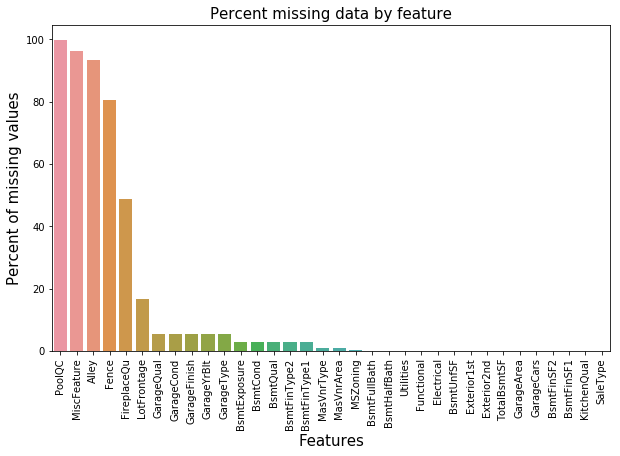

In [17]:
# Visualising missing data
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Missing Percentage'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

A couple of features look severely depleted, but the rest only suffer a few omissions which means imputing these blank variables certainly becomes an option. To get a better sense for how each feature correlates to the target variable, i'll draw up a correlation matrix, before then tackling the missing data. See below!

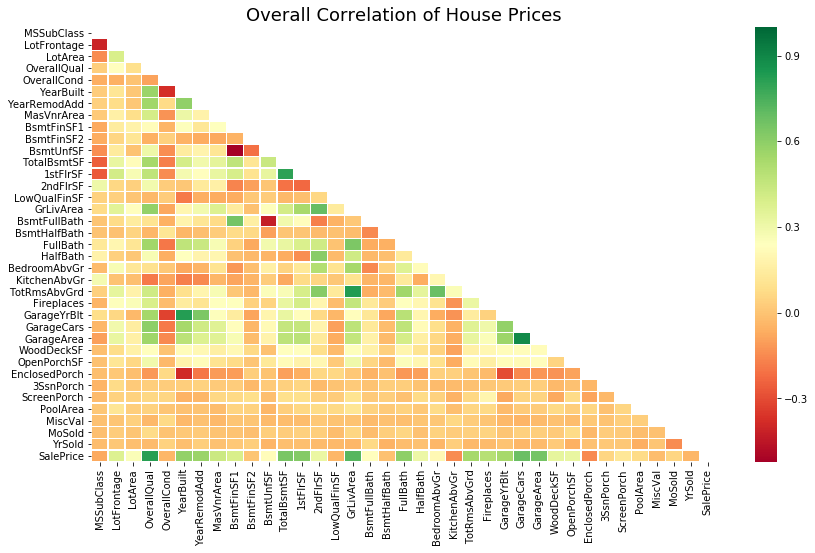

In [18]:
# Initiate correlation matrix
corr = train.corr()
# Set-up mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set-up figure
plt.figure(figsize=(14, 8))
# Title
plt.title('Overall Correlation of House Prices', fontsize=18)
# Correlation matrix
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

Lots of strong correlations on show, especially Overall Quality (not surprising)! Features regarding the Garage are also relating strongly. Right, let's impute the missing values ready for modelling.

### Imputation

I have bundled features into a few different operations depending on what best fits their structure, whether that is replacing with a string or integer to denote zero, or imputation via a specific value. I have spared a lot of the trial and erroring with the final code used to achieve 0 missing values across both datasets.

In [19]:
# All columns where missing values can be replaced with 'None'
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

In [20]:
# All columns where missing values can be replaced with 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

In [21]:
# All columns where missing values can be replaced with the mode (most frequently occurring value)
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [22]:
# Imputing LotFrontage with the median (middle) value
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [23]:
# Checking the new missing % count
all_data_missing = (all_data.isnull().sum() / len(all_data)) * 100
all_data_missing = all_data_missing.drop(all_data_missing[all_data_missing == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio':all_data_missing})
missing_data.head(30)

,Missing Ratio


Another check on the Missing data table reveals exactly the desired outcome - nothing.

## Converting variables
### Amending dtypes
I am going to perform a few further actions before modelling the data. This will be not an exhaustive engineering process, but instead some simple steps that will hopefully support more powerful future models. 

Firstly, there are some variables that should in fact be categorical rather than numeric, so i'll complete this step below.

In [24]:
# Converting those variables which should be categorical, rather than numeric
for col in ('MSSubClass', 'OverallCond', 'YrSold', 'MoSold'):
    all_data[col] = all_data[col].astype(str)
    
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 79 columns):
1stFlrSF         2917 non-null int64
2ndFlrSF         2917 non-null int64
3SsnPorch        2917 non-null int64
Alley            2917 non-null object
BedroomAbvGr     2917 non-null int64
BldgType         2917 non-null object
BsmtCond         2917 non-null object
BsmtExposure     2917 non-null object
BsmtFinSF1       2917 non-null float64
BsmtFinSF2       2917 non-null float64
BsmtFinType1     2917 non-null object
BsmtFinType2     2917 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2917 non-null object
BsmtUnfSF        2917 non-null float64
CentralAir       2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
Electrical       2917 non-null object
EnclosedPorch    2917 non-null int64
ExterCond        2917 non-null object
ExterQual        2917 non-null object
Exterior1st      29

### Transforming skewed feature variables
Ok, the dataset is starting to look better. I considered and fixed for skew within the Target variable earlier on, let's now do the same for all remaining numeric Feature variables.

In [25]:
# Applying a log(1+x) transformation to all skewed numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Compute skewness
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


<b>Box Cox Transformation of (highly) skewed features</b>

Skewed features are a formality when dealing with real-world data. Transformation techniques can help to stabilize variance, make data more normal distribution-like and improve the validity of measures of association.

The problem with the Box-Cox Transformation is estimating lambda. This value will depend on the existing data, and as such should be considered when performing cross validation on out of sample datasets.

In [26]:
# Check on number of skewed features above 75% threshold
skewness = skewness[abs(skewness) > 0.75]
print("Total number of features requiring a fix for skewness is: {}".format(skewness.shape[0]))

Total number of features requiring a fix for skewness is: 32


In [27]:
# Now let's apply the box-cox transformation to correct for skewness
skewed_features = skewness.index
lam = 0.15
for feature in skewed_features:
    all_data[feature] = boxcox1p(all_data[feature], lam)

### New feature
I'm also going to create a new feature to bring together a few similar Features, into an overall 'Total Square Footage'.

In [28]:
# Creating a new feature: Total Square Footage
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### Class imbalance
Lastly, a test for any significance class imbalance. Any variable that is represented by a single class by greater than 97% will be removed from the datasets. I also explored the same strategy at the 95% level, but found that model performance decreased ever so slightly with the removal of two further features - LandSlope & MiscFeature. Thus, I will stick at the 97% level.

In [29]:
# Identifying features where a class is over 97% represented
low_var_cat = [col for col in all_data.select_dtypes(exclude=['number']) if 1 - sum(all_data[col] == mode(all_data[col]))/len(all_data) < 0.03]
low_var_cat

['Condition2', 'Heating', 'PoolQC', 'RoofMatl', 'Street', 'Utilities']

In [30]:
# Dropping these columns from both datasets
all_data = all_data.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'PoolQC'], axis=1)

### Label encoding
This step build on the previous step whereby all text data will become numeric. This is a requirement for Machine Learning, that is, only numerical data can be fed into a predictive model. There are many other encoding techniques available, some of which more powerful than Label Encoding which does incur the risk of falsely ranking variables, e.g. coding three locations into 0, 1 and 2 might imply that 2 is a higher value than 0, which is incorrect as the numbers just represent different categories (locations). This is a simple approach, however, and therefore I'm going to stick with it for the current kernel.

Check out this link for more on encoding data: 
https://www.kdnuggets.com/2015/12/beyond-one-hot-exploration-categorical-variables.html

In [31]:
# List of columns to Label Encode
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# Process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# Check on data shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 74)


### Get dummies
I will now round up the feature engineering stage of this project by creating dummy variables ready for model building.

In [32]:
# Get dummies
all_data = pd.get_dummies(all_data)

all_data.shape

(2917, 197)

In [33]:
# Now to return to separate train/test sets for Machine Learning
train = all_data[:ntrain]
test = all_data[ntrain:]

# Machine Learning
## Set-up
Before modelling I am going to define a function that returns the cross-validation 'rmse' error, following 10-folds. This will ensure that all rmse scores produced have been smoothed out across the entire dataset and are not a result of any irregularities, which otherwise would provide a misleading representation of model performance. And that, we do not want.

In [34]:
# Set up variables
X_train = train
X_test = test

# Defining two rmse_cv functions
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

With the rmse_cv function in place, I am going to tackle modelling in three phases - hopefully making it easy to follow:

1. Initiating algorithms
2. Fitting algorithms
3. Stacking algorithms

## 1. Initiating algorithms
I'm going to be working with two broad sets of algorithms within this kernel:

1. Generalized linear models
2. Ensemble methods (specifically Gradient Tree Boosting)

### A. Generalized linear models
I'm going to specifically focus on 'regularised' regression models within this section. <b>Regularisation</b> is a form of regression that shrinks (or 'regularises') the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, so as to avoid the risk of overfitting. This will be particularly helpful for the current dataset where the model needs to account for ~80 features.

There are different types of regularised regressions - I will now explore each of them.

#### 1. Ridge Regression (<i>L2 Regularisation</i>)
Ridge regression shrinks the regression coefficients, so that variables, with minor contribution to the outcome, have their coefficients <b>close to zero.</b>

The shrinkage of the coefficients is achieved by penalizing the regression model with a penalty term called L2-norm, which is the sum of the squared coefficients.

For regularised regression models, the key tuning parameter is <b>alpha</b> - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data. Thus I will define multiple alpha's, iterate over them and plot the result so we can easily see the optimal alpha level.

In [35]:
# Setting up list of alpha's
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30]

# Iterate over alpha's
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

Text(0,0.5,'Rmse')

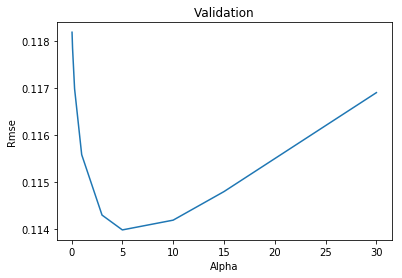

In [36]:
# Plot findings
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

In [37]:
# 5 looks like the optimal alpha level, so let's fit the Ridge model with this value
model_ridge = Ridge(alpha = 5)

#### 2. Lasso Regression <i>(L1 regularisation)</i> 
Lasso stands for Least Absolute Shrinkage and Selection Operator. It shrinks the regression coefficients toward zero by penalizing the regression model with a penalty term called L1-norm, which is the sum of the absolute coefficients.

In the case of lasso regression, the penalty has the effect of forcing some of the coefficient estimates, with a minor contribution to the model, to be <b>exactly equal to zero</b>. This means that, lasso can be also seen as an alternative to the subset selection methods for performing variable selection in order to reduce the complexity of the model. For this reason, I usually prefer working with the Lasso algorithm over Ridge.

Let's take the same appraoch to alpha selection, before initiating the Lasso model.

Text(0,0.5,'Rmse')

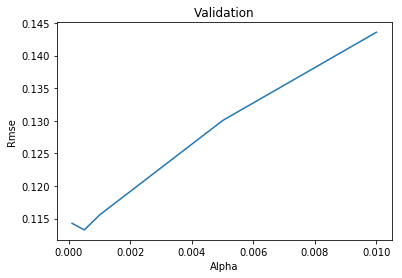

In [38]:
# Setting up list of alpha's
alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]

# Iterate over alpha's
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]

# Plot findings
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

An addition to the Lasso model - I will use a Pipeline to scale features. For the L1 norm to work properly, it's essential this step is taken before fitting the model.

In [39]:
# Initiating Lasso model
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005))

#### 3. ElasticNet Regression
Elastic Net produces a regression model that is penalized with both the L1-norm and L2-norm. The consequence of this is to effectively shrink coefficients (like in ridge regression) and to set some coefficients to zero (as in LASSO).

Text(0,0.5,'Rmse')

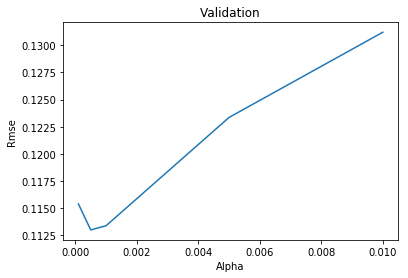

In [40]:
# Setting up list of alpha's
alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]

# Iterate over alpha's
cv_elastic = [rmse_cv(ElasticNet(alpha = alpha)).mean() for alpha in alphas]

# Plot findings
cv_elastic = pd.Series(cv_elastic, index = alphas)
cv_elastic.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

Again, i'll be using RobustScaler to scale all features before initiating the ElasticNet model.

In [41]:
# Initiating ElasticNet model
model_elastic = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005))

#### 4. Kernel ridge regression
OK, this is not strictly a generalized linear model. Kernel ridge regression (KRR) combines Ridge Regression (linear least squares with l2-norm regularization) with the 'kernel trick'. It thus learns a linear function in the space induced by the respective kernel and the data. For non-linear kernels, this corresponds to a non-linear function in the original space.

Text(0,0.5,'Rmse')

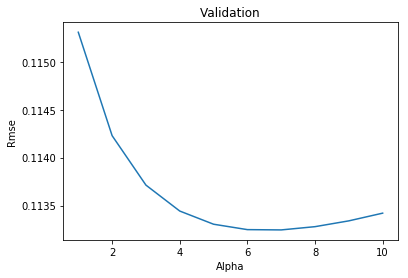

In [42]:
# Setting up list of alpha's
alphas = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# Iterate over alpha's
cv_krr = [rmse_cv(KernelRidge(alpha = alpha)).mean() for alpha in alphas]

# Plot findings
cv_krr = pd.Series(cv_krr, index = alphas)
cv_krr.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

As well as scaling features again for the Kernel ridge regression, I've defined a few more parameters within this algorithm:

- Kernel: Polynomial
    - <i>This means that the algorithm will not just consider similarity between features, but also similarity           between combinations of features.</i>
- Degree & Coef0: 
    - <i>These are used to define the precise structure of the Polynomial kernel. I arrived at the below numbers          through a bit of trial and error. Implementing a GridSearchCV would probably yield a better overall fit.</i>

In [43]:
# Initiatiing KernelRidge model
model_krr = make_pipeline(RobustScaler(), KernelRidge(alpha=6, kernel='polynomial', degree=2.65, coef0=6.9))

### B. Ensemble methods (Gradient tree boosting)
Boosting is an ensemble technique in which the predictors are not made independently, but sequentially.

This technique employs the logic in which the subsequent predictors learn from the mistakes of the previous predictors. Therefore, the observations have an unequal probability of appearing in subsequent models and ones with the highest error appear most. The predictors can be chosen from a range of models like decision trees, regressors, classifiers etc. Because new predictors are learning from mistakes committed by previous predictors, it takes less time/iterations to reach close to actual predictions. But we have to choose the stopping criteria carefully or it could lead to overfitting on training data. Gradient Boosting is an example of a boosting algorithm, and these are what i'll be applying to the current data next.

#### 5. Gradient Boosting
For the Gradient Boosting algorithm I will use 'huber' as the loss function as this is robust to outliers. The other parameters on display originate from other kernels tackling this challenge, followed by trial and error to refine them to this specific dataset. Again, applying GridSearchCV will help to define a better set of parameters than those currently on display.

For the Gradient Boosting model I will use 'huber' as the loss function as this is robust to outliers.

In [44]:
# Initiating Gradient Boosting Regressor
model_gbr = GradientBoostingRegressor(n_estimators=1200, 
                                      learning_rate=0.05,
                                      max_depth=4, 
                                      max_features='sqrt',
                                      min_samples_leaf=15, 
                                      min_samples_split=10, 
                                      loss='huber',
                                      random_state=5)

#### 6. XGBoost
Another gradient boosting algorithm; one that's well documented as being the key to many winning solutions on Kaggle.

In [45]:
# Initiating XGBRegressor
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2,
                             learning_rate=0.06,
                             max_depth=3,
                             n_estimators=1150)

#### 7. LightGBM
A more recent gradient boosting algorithm which boasts significantly faster runtime than XGBoost, while still offering best-in-class predictive power.

In [46]:
# Initiating LGBMRegressor model
model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=4,
                              learning_rate=0.05, 
                              n_estimators=1080,
                              max_bin=75, 
                              bagging_fraction=0.80,
                              bagging_freq=5, 
                              feature_fraction=0.232,
                              feature_fraction_seed=9, 
                              bagging_seed=9,
                              min_data_in_leaf=6, 
                              min_sum_hessian_in_leaf=11)

#### 8. CatBoost
All the way from Russia, CatBoost is a new gradient boosting algorithm able to work with categorical features <b>without</b> any prior processing needed. I am still finding my feet with implementing the CatBoostRegressor - thus this section of the kernel is very much a work in progress. Any guidance on working with this algorithm would be greatly appreciated - especially with regards to performing cross-validation and hyperparameter tuning. The below parameters again came from my own trial & error.

In [47]:
# Initiating CatBoost Regressor model
model_cat = CatBoostRegressor(iterations=2000,
                              learning_rate=0.10,
                              depth=3,
                              l2_leaf_reg=4,
                              border_count=15,
                              loss_function='RMSE',
                              verbose=200)

# Initiating parameters ready for CatBoost's CV function, which I will use below
params = {'iterations':2000,
          'learning_rate':0.10,
          'depth':3,
          'l2_leaf_reg':4,
          'border_count':15,
          'loss_function':'RMSE',
          'verbose':200}

## 2. Fitting algorithms

### Fit all models
I'll now run the custom rmse_cv function on each algorithm to understand each model's performance. This function doesn't work for the CatBoost algorithm, so I will just fit this for now and will return with a solution at a later date.

In [48]:
# Fitting all models with rmse_cv function, apart from CatBoost
cv_ridge = rmse_cv(model_ridge).mean()
cv_lasso = rmse_cv(model_lasso).mean()
cv_elastic = rmse_cv(model_elastic).mean()
cv_krr = rmse_cv(model_krr).mean()
cv_gbr = rmse_cv(model_gbr).mean()
cv_xgb = rmse_cv(model_xgb).mean()
cv_lgb = rmse_cv(model_lgb).mean()

In [49]:
# Define pool
pool = Pool(X_train, y_train)

# CV Catboost algorithm
cv_cat = cv(pool=pool, params=params, fold_count=10, shuffle=True)

0:	learn: 10.8459720	test: 10.8460561	best: 10.8460561 (0)
200:	learn: 0.1536797	test: 0.1744133	best: 0.1744133 (200)
400:	learn: 0.1372453	test: 0.1624508	best: 0.1624508 (400)
600:	learn: 0.1285924	test: 0.1569804	best: 0.1569747 (599)
800:	learn: 0.1232898	test: 0.1533305	best: 0.1533305 (800)
1000:	learn: 0.1193540	test: 0.1512141	best: 0.1512014 (997)
1200:	learn: 0.1161644	test: 0.1495673	best: 0.1495673 (1200)
1400:	learn: 0.1135416	test: 0.1482640	best: 0.1482614 (1395)
1600:	learn: 0.1114722	test: 0.1476049	best: 0.1475962 (1598)
1800:	learn: 0.1093993	test: 0.1463895	best: 0.1463895 (1800)
1999:	learn: 0.1077123	test: 0.1452257	best: 0.1452209 (1998)	total: 1m 1s	remaining: 0us


In [50]:
# Select best model
cv_cat = cv_cat.at[1999, 'train-RMSE-mean']

### Rank model performance
The moment of truth - let's see how each algorithm has performed, and which one tops the pile.

In [51]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': ['Ridge',
              'Lasso',
              'ElasticNet',
              'Kernel Ridge',
              'Gradient Boosting Regressor',
              'XGBoost Regressor',
              'Light Gradient Boosting Regressor',
              'CatBoost'],
    'Score': [cv_ridge,
              cv_lasso,
              cv_elastic,
              cv_krr,
              cv_gbr,
              cv_xgb,
              cv_lgb,
              cv_cat]})

# Build dataframe of values
result_df = results.sort_values(by='Score', ascending=True).reset_index(drop=True)
result_df.head(8)

,Model,Score
0,CatBoost,0.107712
1,Lasso,0.111625
2,ElasticNet,0.111778
3,XGBoost Regressor,0.112392
4,Gradient Boosting Regressor,0.113159
5,Ridge,0.113991
6,Light Gradient Boosting Regressor,0.114029
7,Kernel Ridge,0.116458


Text(0.5,1,'RMSE')

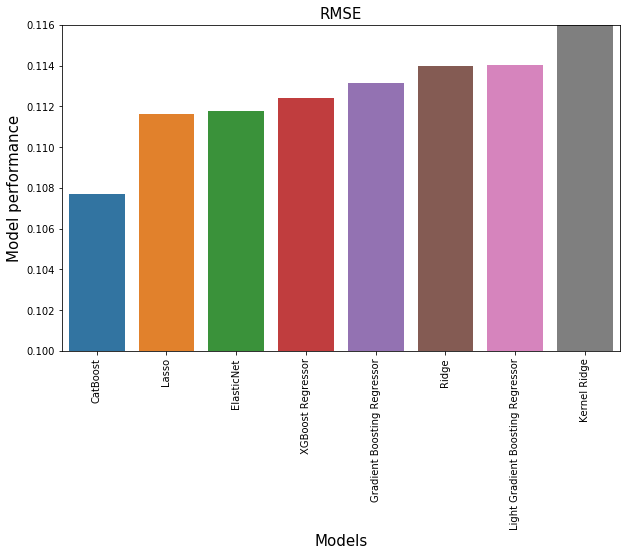

In [52]:
# Plotting model performance
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model performance', fontsize=15)
plt.ylim(0.10, 0.116)
plt.title('RMSE', fontsize=15)

We can see from the above graph that the LASSO and ElasticNet are the best cross-validated models, scoring very closely to one another. Gradient boosting hasn't fared quite as well, however each algorithm still obtains a very respectable RMSE. The CatBoost model has not been cross-validated so I am not going to consider this algorithm (for the time being). 

## 3. Stacking algorithms
I've ran eight models thus far, and they've all performed pretty well. I'm now quite keen to explore stacking as a means of achieving an even higher score. In a nutshell, stacking uses as a first-level (base) the predictions of a few basic classifiers and then uses another model at the second-level to predict the output from the earlier first-level predictions. Stacking can be beneficial as combining models allows the best elements of their predictive power on the given challenged to be pooled, thus smoothing over any gaps left from an individual model and increasing the likelihood of stronger overall model performance.

Ok, let's get model predictions and then stack the results!

In [53]:
# Fit and predict all models
model_lasso.fit(X_train, y_train)
lasso_pred = np.expm1(model_lasso.predict(X_test))

model_elastic.fit(X_train, y_train)
elastic_pred = np.expm1(model_elastic.predict(X_test))

model_ridge.fit(X_train, y_train)
ridge_pred = np.expm1(model_ridge.predict(X_test))

model_xgb.fit(X_train, y_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))

model_gbr.fit(X_train, y_train)
gbr_pred = np.expm1(model_gbr.predict(X_test))

model_lgb.fit(X_train, y_train)
lgb_pred = np.expm1(model_lgb.predict(X_test))

model_krr.fit(X_train, y_train)
krr_pred = np.expm1(model_krr.predict(X_test))

model_cat.fit(X_train, y_train)
cat_pred = np.expm1(model_cat.predict(X_test))

0:	learn: 10.8409510	total: 6.92ms	remaining: 13.8s
200:	learn: 0.1552554	total: 673ms	remaining: 6.02s
400:	learn: 0.1414376	total: 1.3s	remaining: 5.2s
600:	learn: 0.1368015	total: 1.92s	remaining: 4.46s
800:	learn: 0.1325564	total: 2.56s	remaining: 3.83s
1000:	learn: 0.1294124	total: 3.18s	remaining: 3.18s
1200:	learn: 0.1260474	total: 3.82s	remaining: 2.54s
1400:	learn: 0.1237258	total: 4.46s	remaining: 1.91s
1600:	learn: 0.1224529	total: 5.09s	remaining: 1.27s
1800:	learn: 0.1185367	total: 5.74s	remaining: 635ms
1999:	learn: 0.1171462	total: 6.38s	remaining: 0us


## Final predictions
Now to create the stacked model! I'm going to keep this very simple by equally weighting every model. This is done by summing together the models and then dividing by the total count. Weighted averages could be a means of gaining a slightly better final predictions, whereby the best performing models take a bigger cut of the stacked model. One of the more important considerations when undertaking any kind of model stacking is model independence. Stacking models that draw similar conclusions from the data is quite unlikely to yield a better score compared to a single model, because there's no additional insight being drawn out. Rather, model's that tackle the dataset in different ways, and that are able to detect unique aspects within it stand a better chance of contributing to a more powerful overall stacked model, since as a whole, more of the nuances within the data have been recognised and accounted for.

Please note, I am not going to include the CatBoost model as I found the model prediction declined when this was included - looks at the output it appears as though it is overfitting the data (visible through the differing learn/test scores). I will return to this model later with a view to improve it's application to the current dataset.

In [54]:
# Create stacked model
stacked = (lasso_pred + elastic_pred + ridge_pred + xgb_pred + lgb_pred + krr_pred + gbr_pred) / 7

In [55]:
# Setting up competition submission
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = stacked
sub.to_csv('house_price_predictions.csv',index=False)

And there you have it! Within this kernel I have performed simple data preparation techniques before applying several models, and then combining their performance into a single stacked model. This achieved a final RMSE that pitched me within the top 12% of the leaderboard.

I hope the approach and techniques on display in this kernel have been helpful in terms of not just solving the current challenges, but other regression and broader machine learning challenges. 

If this kernel has indeed helped you - i'd very much like to hear it :). Please also share with me any suggestions that could improve my final model, i'm always looking to learn more. In terms of future version, I aim to tackle the following:

- Perfecting the CatBoost model
- Performing a more rigorous GridSearchCV
- Exploring more complex methods of model stacking for better final prediction.

Thank you for reading :). 